In [3]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.5 MB/s eta 0:00:00


In [67]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
import datetime
from tqdm import tqdm
import warnings

ARMA Stock Prediction
1. Get a ticker (e.g. SAP)
2. Get daily returns from ticker for training (e.g. last 30 days)

Check assumptions of ARMA
3. Check stationarity by ADF (Augmented Dickey Fuller test) 
   - no seasonality, same expectation and same variance
   - If not, PASS and take another ticker
4. Draw ACF (MA) and PACF (AR)
5. Fit model to 30 days stock return (if nothing significant -> PASS)
6. Predict tomorrow y+
7. Give 95% confidence interval (x_low, x_high)
8. If y+ is in (x_low, x_high) => +1, else => 0

Backtesting
- Dont only look at one 30 day training time
    - From yesterday, look back 30 days
        - Fit ARMA, predict today, show if prediction is in 95% CI
    - From yesterday - 1, look back 30 days 
        - again \


=> We get probability P(fit) to fit the model and P(CI inc.) of how often the ARMA model predicts correctly

- Iterate over every ticker in DAX -> Get these probabilities for every ticker
- Output 40 (dax comps) x number of days backtested (30)

In [5]:
dax = yf.Ticker("^GDAXI")
#dax_list = dax.recommendations.index.tolist()

print(dax)

yfinance.Ticker object <^GDAXI>


In [6]:
# Get SAP ticker last 60 days
sap = yf.Ticker("SAP.DE")
sap_data = sap.history(period="60d")
print(sap_data.head(5))
print(sap_data.tail(1))
print(sap_data.shape)

                                 Open        High         Low       Close  \
Date                                                                        
2023-01-13 00:00:00+01:00  107.279999  108.000000  106.980003  107.639999   
2023-01-16 00:00:00+01:00  107.940002  107.940002  107.019997  107.419998   
2023-01-17 00:00:00+01:00  107.059998  108.279999  106.180000  107.300003   
2023-01-18 00:00:00+01:00  108.000000  109.419998  107.400002  109.000000   
2023-01-19 00:00:00+01:00  108.480003  108.599998  106.019997  106.500000   

                            Volume  Dividends  Stock Splits  
Date                                                         
2023-01-13 00:00:00+01:00  1774166        0.0           0.0  
2023-01-16 00:00:00+01:00   952506        0.0           0.0  
2023-01-17 00:00:00+01:00  1482660        0.0           0.0  
2023-01-18 00:00:00+01:00  1656208        0.0           0.0  
2023-01-19 00:00:00+01:00  2203122        0.0           0.0  
                          

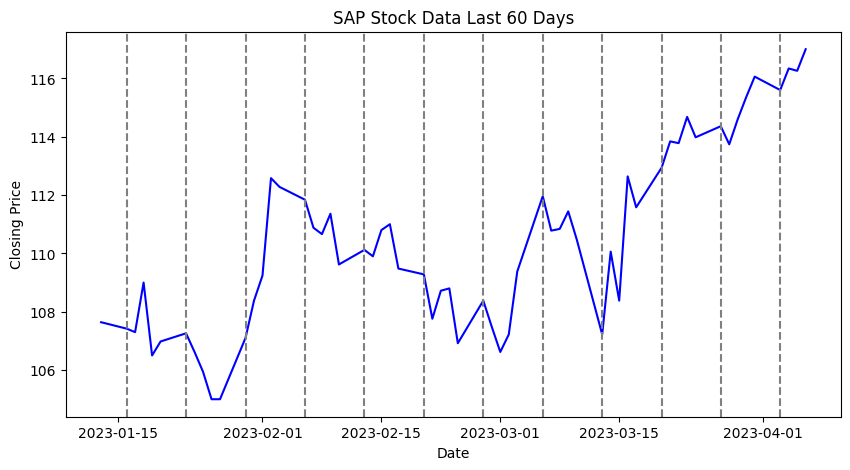

In [7]:
# Preprocessing: Delete first and last row
#sap_data = sap_data.iloc[1:-1]

# Plot the stock data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sap_data.index, sap_data['Close'], color='blue')

# Add a vertical line for the start of each week (Monday)
for date in sap_data.index:
    if date.weekday() == 0:
        ax.axvline(x=date, color='gray', linestyle='--')

# Set the plot title and axis labels
ax.set_title("SAP Stock Data Last 60 Days")
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")

# Show the plot
plt.show()

In [8]:
# SAP return data
sap_returns = sap_data['Close'].pct_change()

# Remove the first row of sap_returns for prediction
actual = sap_returns.iloc[-1]

# Remove first and last row
sap_returns = sap_returns.iloc[1:-1]

# Transform to series
s = pd.Series(sap_returns)

# Calculate start date by subtracting offset from current date
start_date = sap_returns.index[0].date()

# Generate range of dates with frequency of one week
dates = pd.date_range(start=start_date, periods=len(s), freq='B')

# Set dates as index of Series
s.index = dates

# Re
sap_returns = s

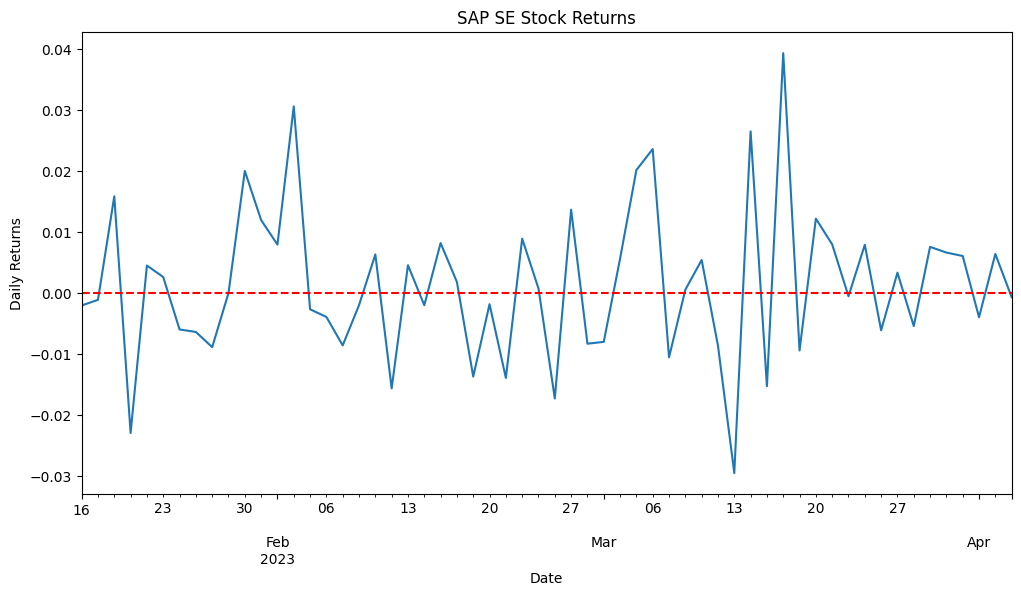

In [9]:
# Plot sap_returns
ax = sap_returns.plot(figsize=(12, 6))
ax.axhline(y=0, color='r', linestyle='--')
plt.title('SAP SE Stock Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()

In [10]:
# Perform Augmented-Dickey-Fuller test for stationarity of returns
result = sm.tsa.stattools.adfuller(sap_returns)
if result[1] < 0.05:
    print(f"{result[1]} => stationar")
else:
    print(f"{result[1]} => not stationar")

1.8700567781076048e-16 => stationar


# Autocorrelation
The ACF measures the correlation between a time series and its lagged values, up to a specified lag order. It shows how much each lagged value is correlated with the current value of the time series. A significant correlation at a specific lag suggests that the corresponding lagged value is an important predictor of the current value, and that the time series is not a random process. \
=> Autocorrelation (ACF): ACF can help us identify the lag order for a moving average (MA) model

# Partial Autocorrelation
The PACF measures the correlation between a time series and its lagged values, after removing the effects of the intervening lags. It shows how much each lagged value is correlated with the current value of the time series, while controlling for the effects of the other lags. A significant correlation at a specific lag suggests that the corresponding lagged value is an important predictor of the current value, after accounting for the effects of the other lags. \
=> The PACF can help us identify the lag order for an autoregressive (AR) model

In [11]:
# calculate ACF values for the first 10 lags
acf_values, confint = sm.tsa.acf(sap_returns, nlags=10, fft=False, alpha=0.05)

# calculate the critical value for a two-tailed test at the 95% significance level
crit_val = 1.96 / (len(sap_returns) ** 0.5)

# create a pandas DataFrame with ACF values, confidence intervals, and significance
lag_values = range(0, 11)
acf_df = pd.DataFrame({'ACF': acf_values, 'Significant': abs(acf_values) > crit_val}, index=lag_values)

# print the DataFrame
print(acf_df)

         ACF  Significant
0   1.000000         True
1  -0.252503        False
2   0.178088        False
3  -0.078843        False
4  -0.073322        False
5  -0.037287        False
6  -0.254102        False
7   0.018539        False
8   0.093535        False
9   0.020098        False
10 -0.053308        False


In [12]:
# calculate PACF values for the first 10 lags
pacf_values, confint = sm.tsa.pacf(sap_returns, nlags=10, alpha=0.05)

# calculate the critical value for a two-tailed test at the 95% significance level
crit_val = 1.96 / (len(sap_returns) ** 0.5)

# create a pandas DataFrame with PACF values, confidence intervals, and significance
lag_values = range(0, 11)
pacf_df = pd.DataFrame({'PACF': pacf_values,'Significant': abs(pacf_values) > crit_val}, index=lag_values)

# print the DataFrame
print(pacf_df)

        PACF  Significant
0   1.000000         True
1  -0.256933        False
2   0.126805        False
3  -0.009991        False
4  -0.133690        False
5  -0.081714        False
6  -0.309522         True
7  -0.138303        False
8   0.175921        False
9   0.078439        False
10 -0.200440        False


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


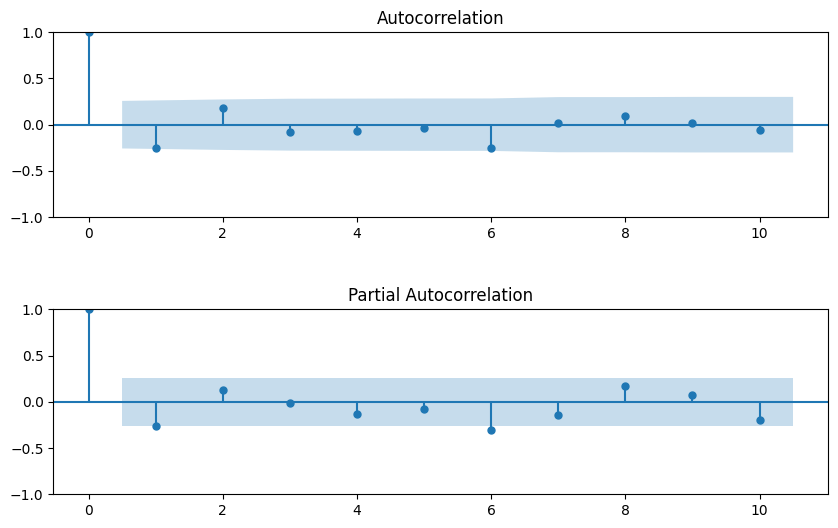

In [13]:
# Plot ACF and PACF
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
tsaplots.plot_acf(sap_returns, lags=10, ax=ax[0])
tsaplots.plot_pacf(sap_returns, lags=10, ax=ax[1])
plt.subplots_adjust(hspace=0.5)
plt.show();

In [14]:
# fit an ARMA model based on the highest significant lag of the ACF and PACF
d = 0 # ARIMA = I = 0
order = (pacf_df.index[pacf_df['Significant'] == True][-1], d,  acf_df.index[acf_df['Significant'] == True][-1])
model = ARIMA(sap_returns, order=order)
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   58
Model:                 ARIMA(6, 0, 0)   Log Likelihood                 176.721
Date:                Fri, 07 Apr 2023   AIC                           -337.443
Time:                        06:23:13   BIC                           -320.959
Sample:                    01-16-2023   HQIC                          -331.022
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.303      0.193      -0.001       0.004
ar.L1         -0.2477      0.136     -1.822      0.068      -0.514       0.019
ar.L2          0.0863      0.148      0.584      0.5

In [15]:
# Use the auto_arima function to select the best ARIMA order
ar_p_max = pacf_df.index[pacf_df['Significant'] == True][-1]
ma_q_max = acf_df.index[acf_df['Significant'] == True][-1]

# Auto Arima, checks the best possible arima model based on aic and bic
model = auto_arima(sap_returns, start_p=0, start_q=0, max_p=ar_p_max, 
                   max_q=ma_q_max, seasonal=False, trace=True)

# Print the summary of the selected model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-340.454, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-341.731, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-340.851, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-340.941, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 172.866
Date:                Fri, 07 Apr 2023   AIC                           -341.731
Time:                        06:23:14   BIC                           -337.610
Sample:                    01-16-2023   HQIC                          -340.126
                         - 04-05-2023                                         
Covariance Type:                  opg                          

In [16]:
# Get best model
best_model = model.order
print(best_model)

# Fit an ARIMA model
model = ARIMA(sap_returns, order=best_model)
results = model.fit()

# Make a prediction
alpha = 0.05
forecast = results.get_forecast(steps=1, alpha=alpha)

# Extract the predicted value and confidence intervals
prediction = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=alpha)

# Print the predicted value
print(f"Actual for {datetime.date.today()}: {actual}")
print(f"Prediction for {datetime.date.today()}: {prediction[0]}")
print(f"{1-alpha}% Confidence Interval for {datetime.date.today()}: {conf_int}")

(1, 0, 0)
Actual for 2023-04-07: 0.0063650253756439845
Prediction for 2023-04-07: 0.0019472575441418687
0.95% Confidence Interval for 2023-04-07:             lower Close  upper Close
2023-04-06    -0.021859     0.025753


In [17]:
# Check if prediction is within confidence interval
if prediction[0] >= conf_int['lower Close'][0] and prediction[0] <= conf_int['upper Close'][0]: 
  print("Prediction is within the confidence interval")
else:
  print("Prediction is outside of the confidence interval")

Prediction is within the confidence interval


**Putting the ARMA model prediction in one function**

*Description*
- ticker: Ticker from stock
- period_days: Number of days we want to use to train the model for prediction

In [18]:
def add_d_to_period(period_days: int) -> str:
    return f"{period_days}d"

In [19]:
def get_ticker(ticker: str, period_days: int):  
    
    # Get ticker for specified period
    tick = yf.Ticker(ticker)
    data = tick.history(period=add_d_to_period(period_days))

    return data

ARMA (AutoRegressive Moving Average) is a time series model that combines both autoregressive (AR) and moving average (MA) components to model the behavior of a time series. The AR component models the relationship between the current value of the time series and its past values, while the MA component models the relationship between the current value of the time series and its past forecast errors.

*Description*
- alpha: Alpha level (usually 0.05)
- lags: Number of lags we want to see for our ARMA model
- model_summary: Get a summary of best ARMA model

In [47]:
def arma(data, alpha: float, lags: int, model_summary: False):

    # Calculate returns
    returns = data['Close'].pct_change()
    # Save the last row of returns for prediction validation
    actual = returns.iloc[-1]
    # Remove first and last row
    returns = returns.iloc[1:-1]

    # Change to date format
    returns = pd.Series(returns)
    start_date = returns.index[0].date()
    dates = pd.date_range(start=start_date, periods=len(returns), freq='B')
    returns.index = dates

    # Perform Augmented-Dickey-Fuller test for stationarity of returns
    result = sm.tsa.stattools.adfuller(returns)
    if not result[1] <= alpha:
      #print(f'Not stationary')
      return ("no stationary")

    # ACF values
    acf_values = sm.tsa.acf(returns, nlags=lags, fft=False, alpha=alpha)[0]
    # calculate the critical value for a two-tailed test at the 95% significance level
    crit_val = 1.96 / (len(returns) ** 0.5)
    # create a pandas DataFrame with ACF values, confidence intervals, and significance
    lag_values = range(0, lags + 1)
    acf_df = pd.DataFrame({'ACF': acf_values, 'Significant': abs(acf_values) > crit_val}, index=lag_values) 
    
    # PACF values
    pacf_values = sm.tsa.pacf(returns, nlags=lags, alpha=alpha)[0]
    # calculate the critical value for a two-tailed test at the 95% significance level
    crit_val = 1.96 / (len(returns) ** 0.5)
    # create a pandas DataFrame with PACF values, confidence intervals, and significance
    lag_values = range(0, lags + 1)
    pacf_df = pd.DataFrame({'PACF': pacf_values,'Significant': abs(pacf_values) > crit_val}, index=lag_values)

    # if no significant lags in acf and pcf, stop
    if ((acf_df.iloc[1:]['Significant'] == False).all() == True) and ((pacf_df.iloc[1:]['Significant'] == False).all() == True):
      #print("No significant lags found in ACF and PCF")
      return ("no acf/pacf significance")

    # Use the auto_arima function to select the best ARIMA order
    ar_p_max = pacf_df.index[pacf_df['Significant'] == True][-1]
    ma_q_max = acf_df.index[acf_df['Significant'] == True][-1]

    # Auto Arima, checks the best possible arima model based on aic and bic
    model = auto_arima(returns, start_p=0, start_q=0, max_p=ar_p_max, 
                      max_q=ma_q_max, seasonal=False, trace=False, maxiter = 1000)
    
    # Print summary of final model
    if model_summary == True: 
      print(model.summary())
    
    # Fit best model
    best_model = model.order
    # Fit an ARIMA model
    model = ARIMA(returns, order=best_model)
    results = model.fit()
    forecast = results.get_forecast(steps=1, alpha=alpha)
    # Extract the predicted value and confidence intervals
    prediction = forecast.predicted_mean
    conf_int = forecast.conf_int(alpha=alpha)
    conf_lower = conf_int['lower Close'][0]
    conf_upper = conf_int['upper Close'][0]
    
    return (actual, prediction[0], conf_lower, conf_upper)

In [45]:
# Get ticker
data = get_ticker("SAP.DE", 60)

# Fit ARMA
arma(data, 0.05, 20, model_summary = True)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 172.866
Date:                Fri, 07 Apr 2023   AIC                           -341.731
Time:                        08:55:05   BIC                           -337.610
Sample:                    01-16-2023   HQIC                          -340.126
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2363      0.122     -1.939      0.052      -0.475       0.003
sigma2         0.0002   2.23e-05      6.753      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

(0.0063650253756439845,
 0.0019472575441418687,
 -0.021858945562596755,
 0.02575346065088049)

**Backtesting**

Backtesting is a process of testing a trading strategy on historical data to evaluate its performance. It involves simulating trades using past market data to assess the profitability and risk of a trading strategy before it is applied in real-time trading.

*Description*
- ticker: Ticker from stock
- period_days: Number of days we want to use to train the model for prediction
- alpha: Alpha level (usually 0.05)
- lags: Number of lags we want to see for our ARMA model
- backtest_days: Number of validation samples (like cross-validation)
- print_rounds: See actual and prediction for each backtesting round


In [74]:
def backtest(ticker: str, period_days: int, alpha: float, lags: int, 
             backtest_days: int, print_rounds: True):
  
    # Period_days has to be bigger than backtest_days
    if period_days < backtest_days: 
      raise ValueError("backtest_days needs to be smaller than period_days")
    
    # Get ticker for specified period
    tick = yf.Ticker(ticker)
    data = tick.history(period=add_d_to_period(period_days + backtest_days))

    # Initialize values to store backtesting results
    tendency = 0
    conf = 0
    stationarity = 0
    significance = 0

    # Loop over each day in the backtesting period
    for i in tqdm(range(backtest_days)):

        # Fit the ARMA model 
        result = arma(data, alpha, lags, model_summary = False)

        # Stop ARMA function
        if isinstance(result, str):
            if result == "no stationary":
              
              stationarity +=1
              # Print backtesting round
              if print_rounds == True:
                print(f"Round {i+1}: Not stationary")           
            else:
              significance +=1
              # Print backtesting round
              if print_rounds == True:
                print(f"Round {i+1}: Not significant")

        # ARMA could be fitted
        else:
            actual, prediction, lower, upper = result

            # Tendency that model predicted negative or positive correctly
            if actual * prediction > 0: 
              tendency += 1 
            
            if prediction >= lower and prediction <= upper: 
              conf += 1

            # Print backtesting round
            if print_rounds == True:
              print(f"Round {i+1}: Prediction: {round(prediction, 5)}, Actual: {round(actual, 5)}")

        # Delete last row from data
        data = data.iloc[:-1]

    # Calculate backtesting rates
    tendency_rate = tendency/backtest_days
    conf_rate = conf/backtest_days
    stationarity_rate = stationarity/backtest_days
    significance_rate = significance/backtest_days

    # Build DataFrame from rates
    df = {
        'Tendency Rate': [tendency_rate],
        'Confidence Rate': [conf_rate],
        'Stationarity Rate': [stationarity_rate],
        'Significance Rate': [significance_rate],
    }

    # Return the backtesting results
    return (pd.DataFrame(df))

Backtesting SAP stock for 10 days with a training set of 60 days on a 5% significance level

In [54]:
# Ignore warnings
warnings.filterwarnings('ignore')

backtest("SAP.DE", 60, 0.05, 15, 10, print_rounds = True)

 10%|█         | 1/10 [00:03<00:34,  3.81s/it]

Round 1: Prediction: 0.00409, Actual: 0.00637


 20%|██        | 2/10 [00:05<00:21,  2.72s/it]

Round 2: Prediction: 0.00103, Actual: -0.00069


 30%|███       | 3/10 [00:07<00:17,  2.45s/it]

Round 3: Prediction: 0.00447, Actual: 0.0064


 40%|████      | 4/10 [00:12<00:19,  3.26s/it]

Round 4: Prediction: 0.0033, Actual: -0.00396


 50%|█████     | 5/10 [00:15<00:16,  3.20s/it]

Round 5: Prediction: 0.00336, Actual: 0.00607


 60%|██████    | 6/10 [00:17<00:11,  2.92s/it]

Round 6: Prediction: 0.00049, Actual: 0.00663


 70%|███████   | 7/10 [00:18<00:06,  2.33s/it]

Round 7: Prediction: 0.00275, Actual: 0.00756


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|████████  | 8/10 [00:19<00:03,  1.90s/it]

Round 8: Prediction: 0.00289, Actual: -0.00542


 90%|█████████ | 9/10 [00:21<00:01,  1.65s/it]

Round 9: Prediction: 0.00288, Actual: 0.00333


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

Round 10: Prediction: 0.00303, Actual: -0.0061


,Tendency Rate,Confidence Rate,Stationarity Rate,Significance Rate
0,0.6,1.0,0.0,0.0


**Testing on DAX**

Installing DAX ticker given from ChatGPT (cutoff September 2021) #excluding wirecard (lol) and daimler

In [72]:
dax_tickers = [
    "ADS.DE",  # Adidas
    "ALV.DE",  # Allianz
    "BAS.DE",  # BASF
    "BAYN.DE",  # Bayer
    "BEI.DE",  # Beiersdorf
    "BMW.DE",  # BMW
    "CON.DE",  # Continental
    "1COV.DE",  # Covestro
    "DBK.DE",  # Deutsche Bank
    "DB1.DE",  # Deutsche Börse
    "DPW.DE",  # Deutsche Post
    "DTE.DE",  # Deutsche Telekom
    "DWNI.DE",  # Delivery Hero
    "EOAN.DE",  # E.ON
    "FME.DE",  # Fresenius Medical Care
    "FRE.DE",  # Fresenius
    "HEI.DE",  # HeidelbergCement
    "HEN3.DE",  # Henkel
    "IFX.DE",  # Infineon Technologies
    "LIN.DE",  # Linde
    "MRK.DE",  # Merck
    "MTX.DE",  # MTU Aero Engines
    "MUV2.DE",  # Munich Re
    "RWE.DE",  # RWE
    "SAP.DE",  # SAP
    "SIE.DE",  # Siemens
    "VNA.DE",  # Vonovia
    "VOW3.DE",  # Volkswagen Group
]

In [76]:
# Ignore warnings
warnings.filterwarnings('ignore')

# lists
names = []
results = []

for ticker in dax_tickers:
    new_row = backtest(ticker, 100, 0.05, 30, 30, print_rounds = False)
    results.append(new_row)

# Convert the list of DataFrames into a single DataFrame
combined_df = pd.concat(results, ignore_index=True)

# Add the names column to the combined DataFrame
combined_df.insert(0, 'Name', dax_tickers)

100%|██████████| 30/30 [00:14<00:00,  2.13it/s]

       Name  Tendency Rate  Confidence Rate  Stationarity Rate  \
0    ADS.DE       0.633333         1.000000           0.000000   
1    ALV.DE       0.500000         1.000000           0.000000   
2    BAS.DE       0.100000         0.433333           0.000000   
3   BAYN.DE       0.600000         0.900000           0.000000   
4    BEI.DE       0.566667         1.000000           0.000000   
5    BMW.DE       0.433333         0.900000           0.000000   
6    CON.DE       0.466667         1.000000           0.000000   
7   1COV.DE       0.066667         0.166667           0.000000   
8    DBK.DE       0.200000         0.366667           0.633333   
9    DB1.DE       0.533333         1.000000           0.000000   
10   DPW.DE       0.633333         1.000000           0.000000   
11   DTE.DE       0.700000         1.000000           0.000000   
12  DWNI.DE       0.333333         0.833333           0.000000   
13  EOAN.DE       0.633333         1.000000           0.000000   
14   FME.D

In [77]:
combined_df

,Name,Tendency Rate,Confidence Rate,Stationarity Rate,Significance Rate
0,ADS.DE,0.633333,1.000000,0.000000,0.000000
1,ALV.DE,0.500000,1.000000,0.000000,0.000000
2,BAS.DE,0.100000,0.433333,0.000000,0.566667
3,BAYN.DE,0.600000,0.900000,0.000000,0.100000
4,BEI.DE,0.566667,1.000000,0.000000,0.000000
5,BMW.DE,0.433333,0.900000,0.000000,0.100000
6,CON.DE,0.466667,1.000000,0.000000,0.000000
7,1COV.DE,0.066667,0.166667,0.000000,0.833333
8,DBK.DE,0.200000,0.366667,0.633333,0.000000
9,DB1.DE,0.533333,1.000000,0.000000,0.000000


In [79]:
# Getting mean values from DAX
mean_values = combined_df.mean()

print(mean_values)

Tendency Rate        0.459524
Confidence Rate      0.879762
Stationarity Rate    0.022619
Significance Rate    0.097619
dtype: float64
